In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
# Load the datasets
df_train = pd.read_csv(r"male_players (legacy).csv")
df_test = pd.read_csv(r"players_22.csv")

C:\Users\derar\AppData\Local\Temp\ipykernel_25192\3281707208.py:2: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(r"male_players (legacy).csv")
C:\Users\derar\AppData\Local\Temp\ipykernel_25192\3281707208.py:3: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(r"players_22.csv")


In [3]:
# Drop irrelevant features from the datasets
irrelevant_features_train= [
    'player_id', 'player_url', 'fifa_version', 'fifa_update','short_name', 'long_name', 'player_positions', 'dob', 'league_id', 'league_name', 'league_level', 'club_jersey_number', 'club_loaned_from',
    'club_joined_date', 'club_contract_valid_until_year', 'nationality_id', 'nationality_name', 'nation_team_id', 'nation_position',	'nation_jersey_number', 'real_face', 'release_clause_eur',	'player_tags',	'player_traits',
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',
    'player_face_url', 'fifa_update_date', 'club_name', 'club_team_id'
]
irrelevant_features_test= [
    'sofifa_id', 'player_url', 'short_name', 'long_name', 'player_positions', 'dob', 'league_name', 'league_level', 'club_jersey_number', 'club_loaned_from',
    'club_joined', 'club_contract_valid_until', 'nationality_id', 'nationality_name', 'nation_team_id', 'nation_position',	'nation_jersey_number', 'real_face', 'release_clause_eur',	'player_tags',	'player_traits',
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',
    'player_face_url', 'club_team_id', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'club_name'
]

df_train.drop(irrelevant_features_train, axis=1, inplace=True)
df_test.drop(irrelevant_features_test, axis=1, inplace=True)

C:\Users\derar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


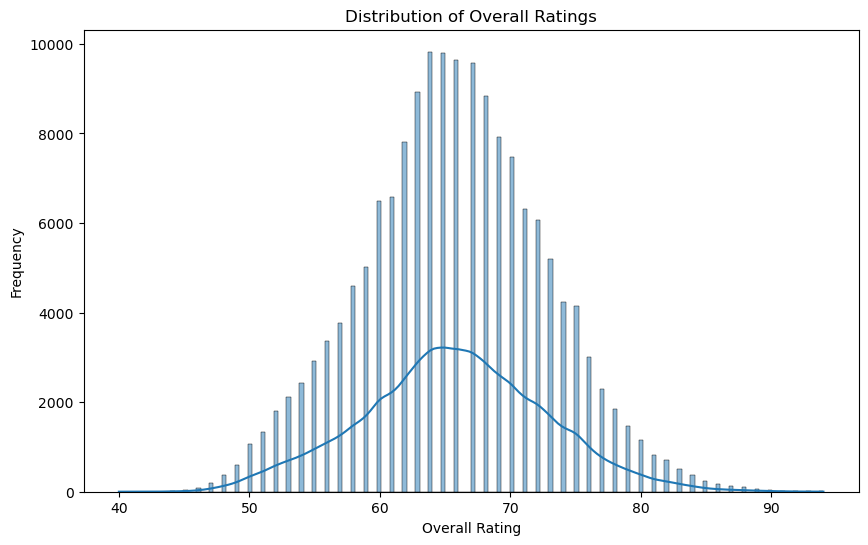

In [4]:
# Visualize distribution of 'overall' (target variable)
plt.figure(figsize=(10, 6))
sns.histplot(df_train['overall'], kde=True)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Separate the numeric and non numeric features
numeric_features = df_train.select_dtypes(include=[np.number])
categorical_features = df_train.select_dtypes(include=[object])

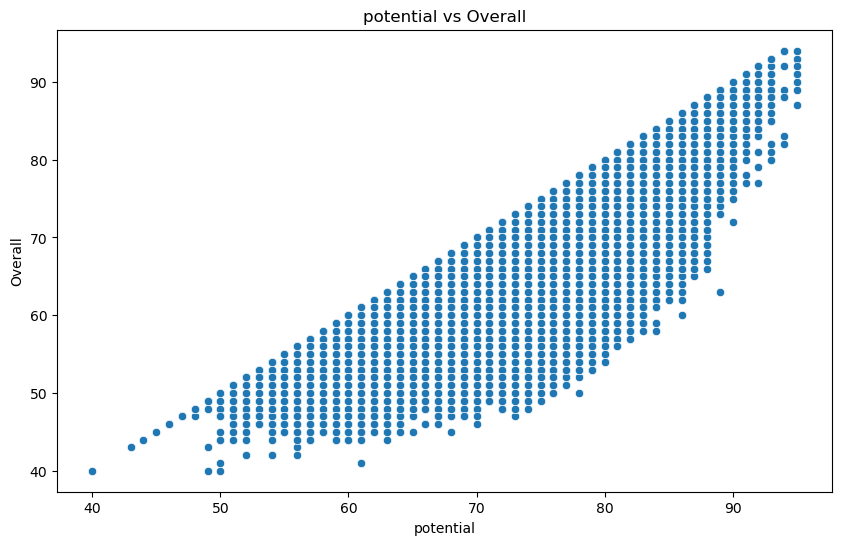

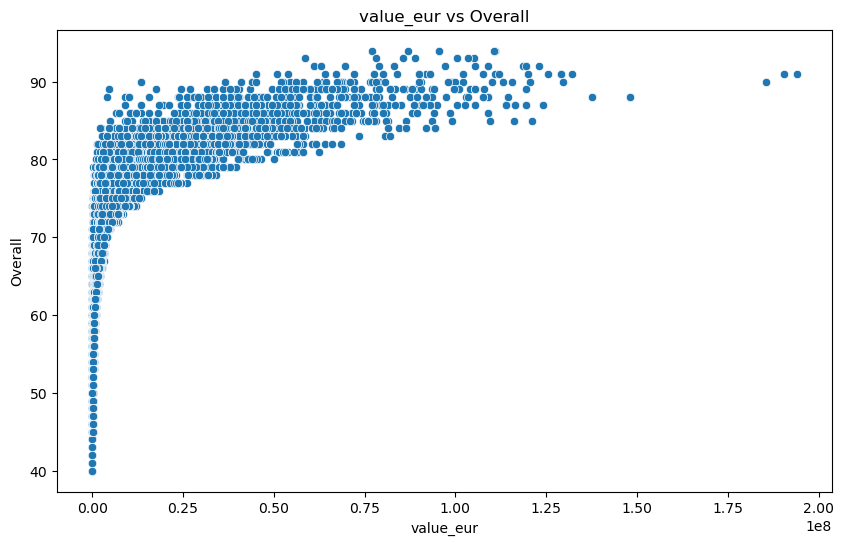

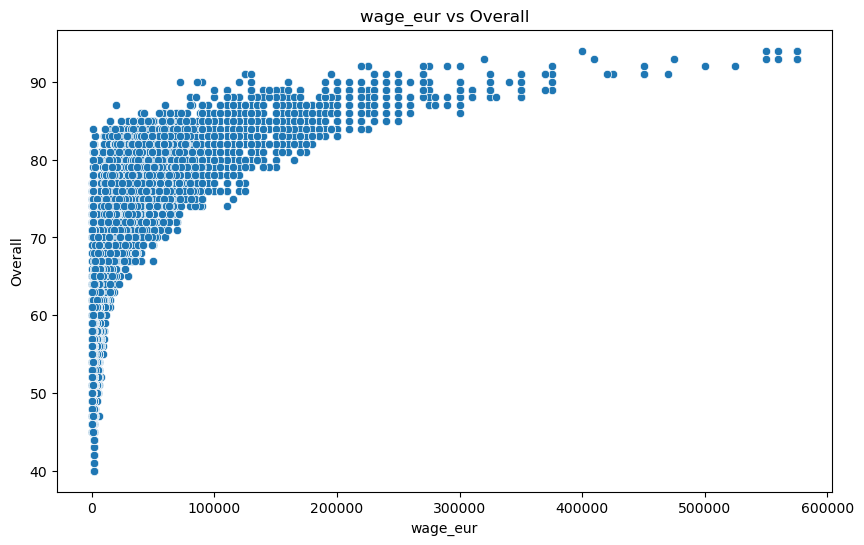

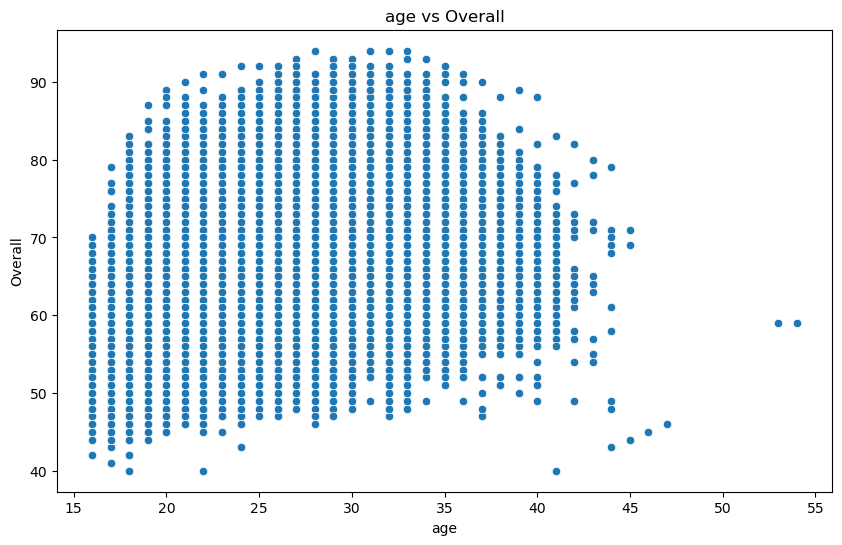

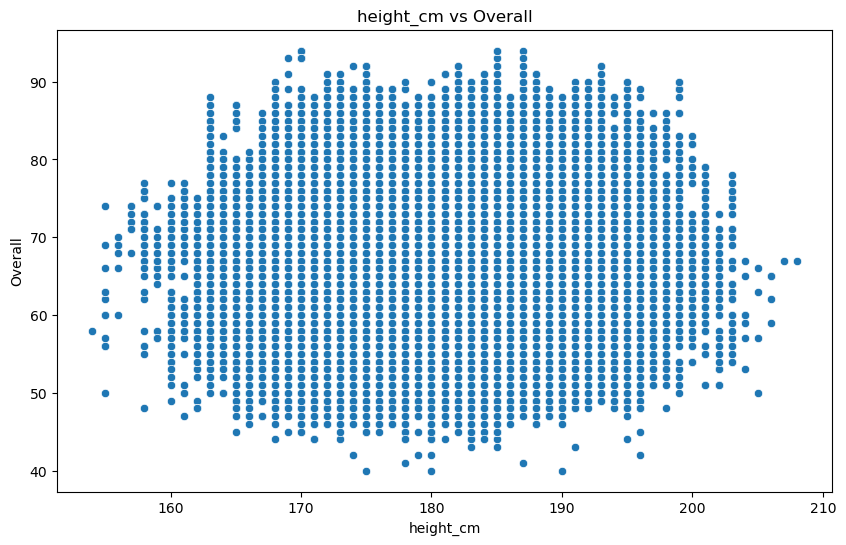

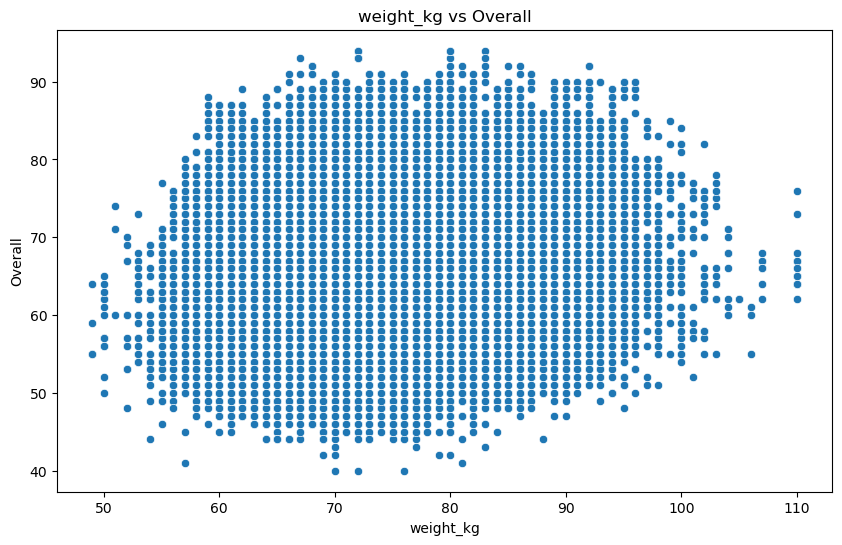

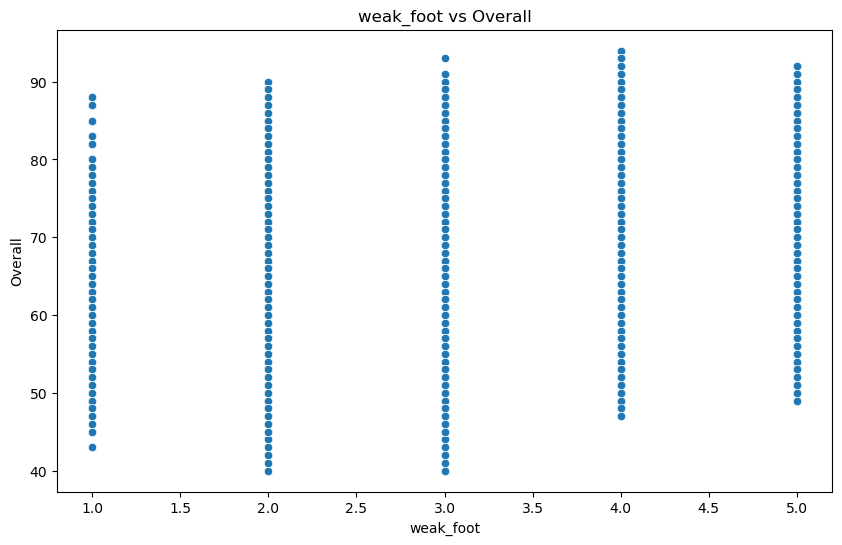

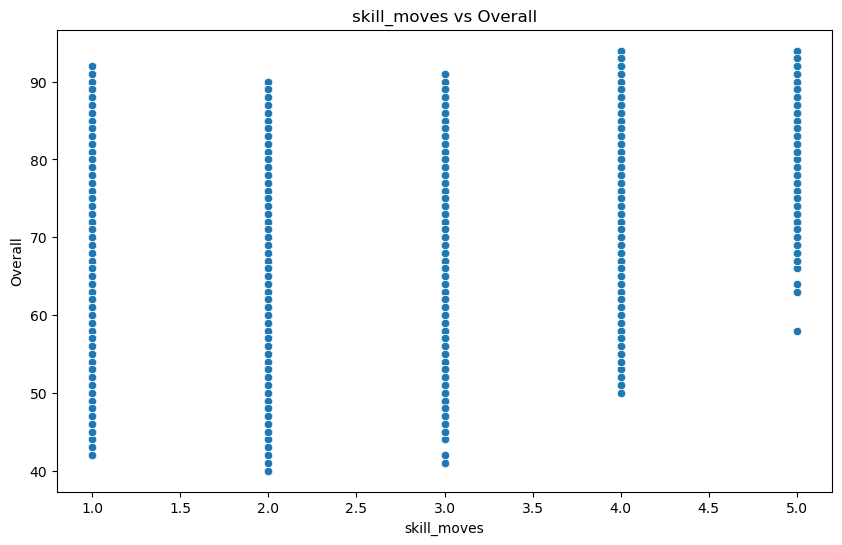

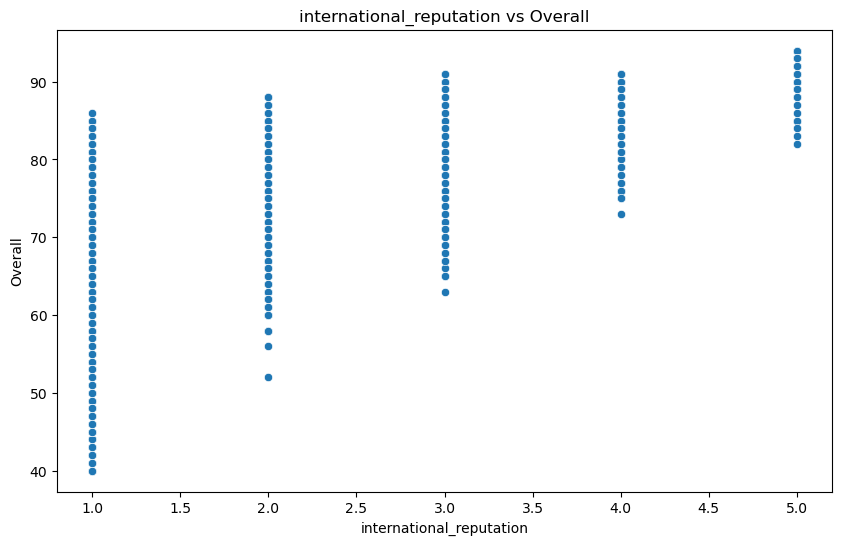

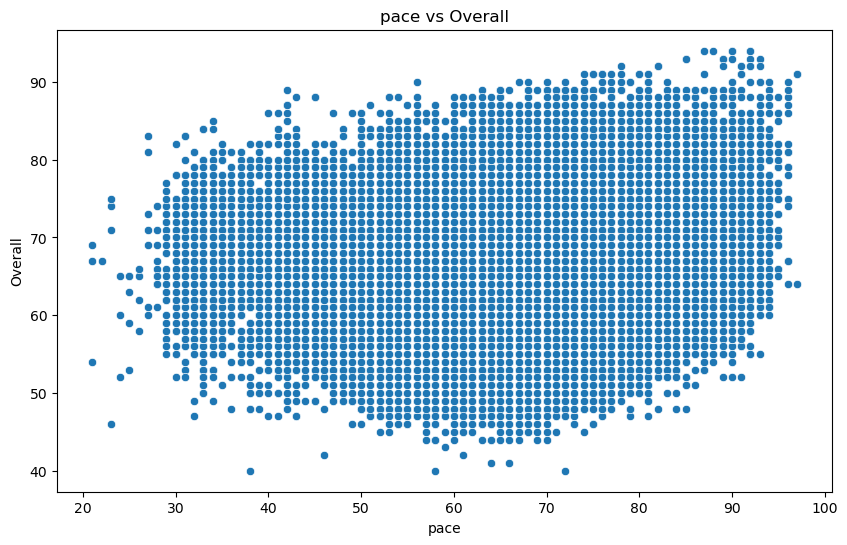

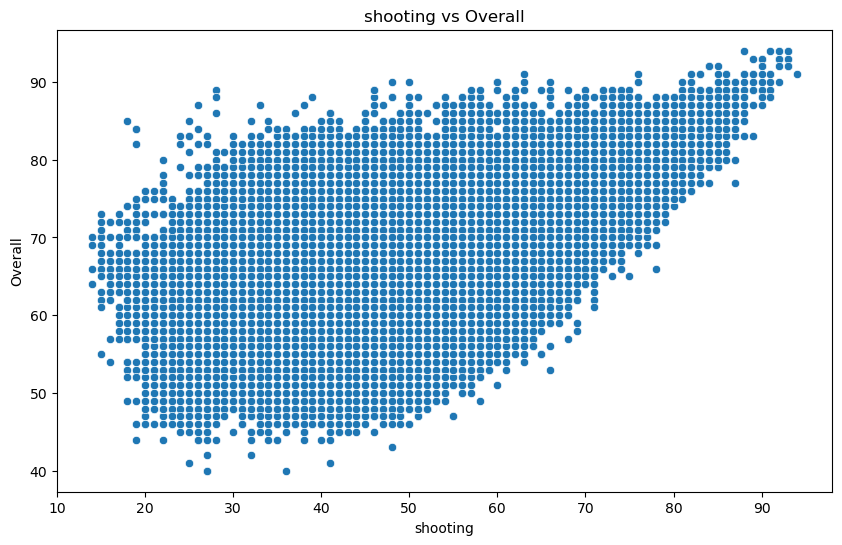

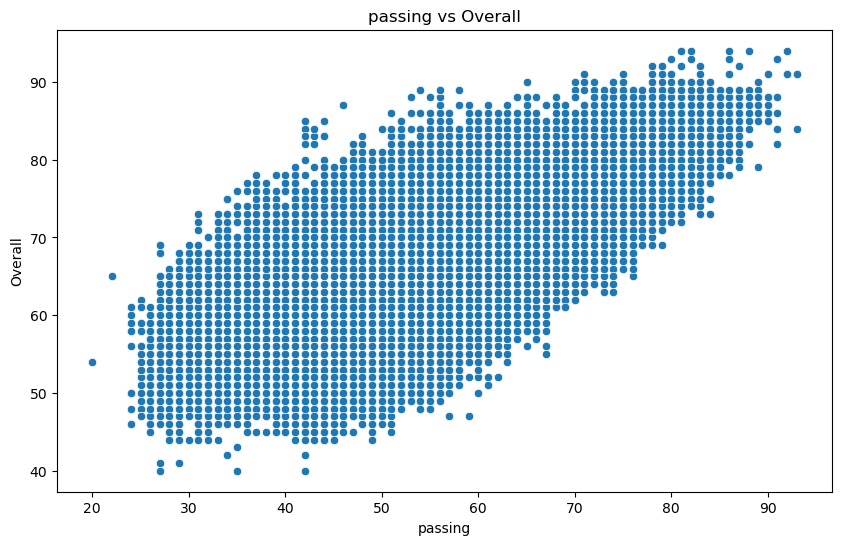

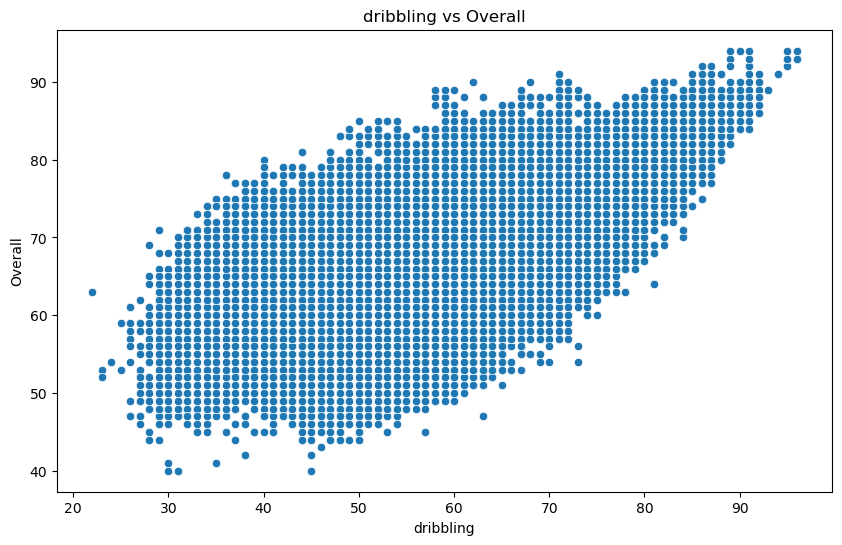

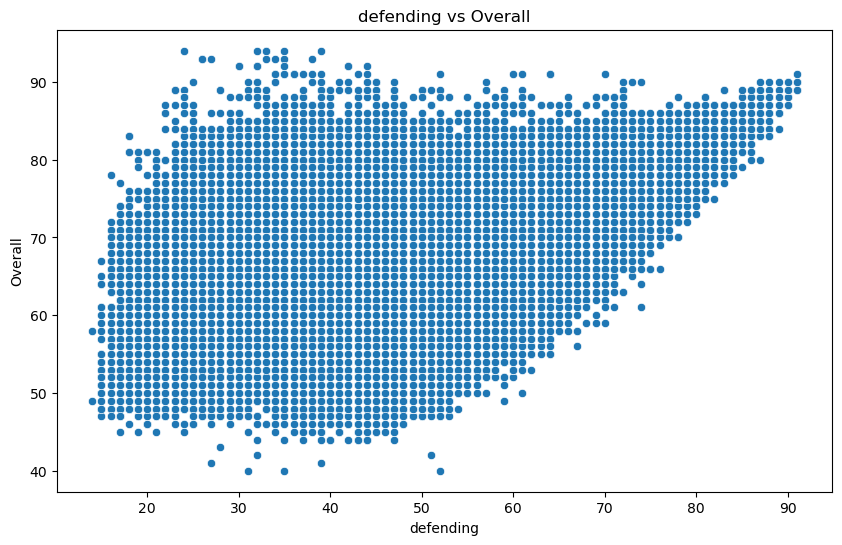

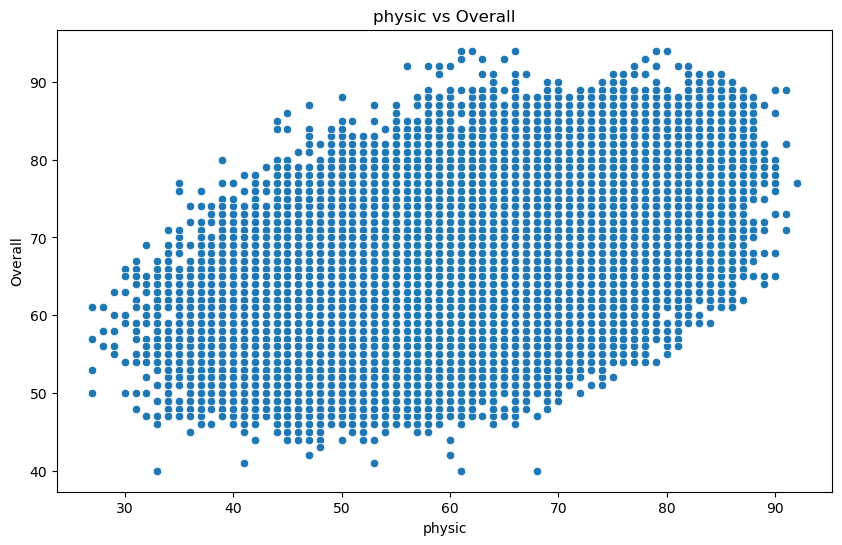

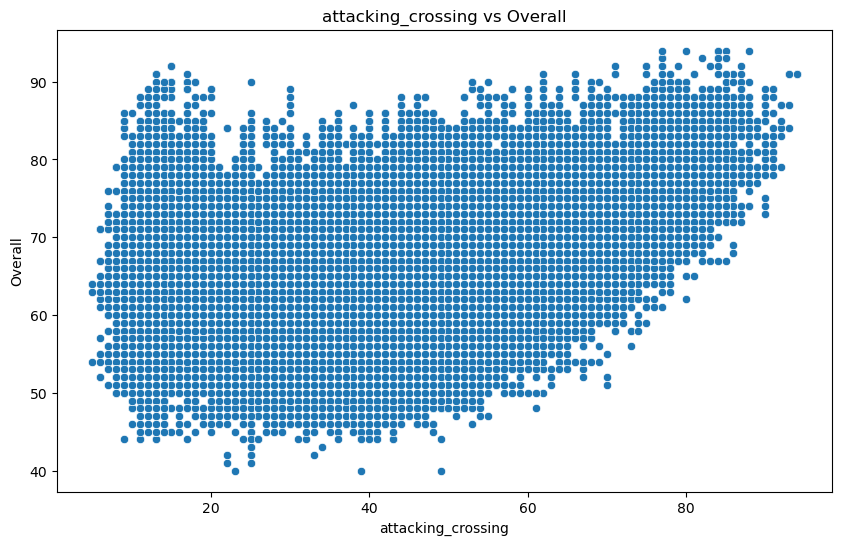

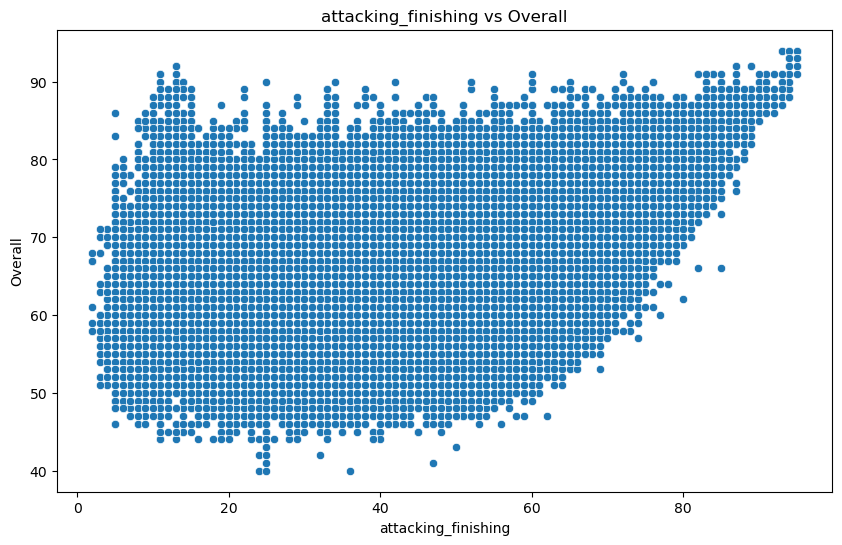

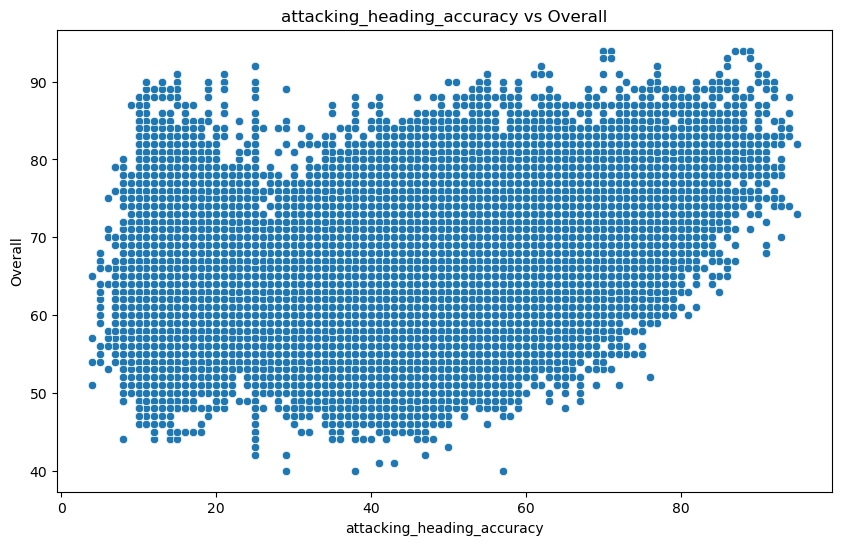

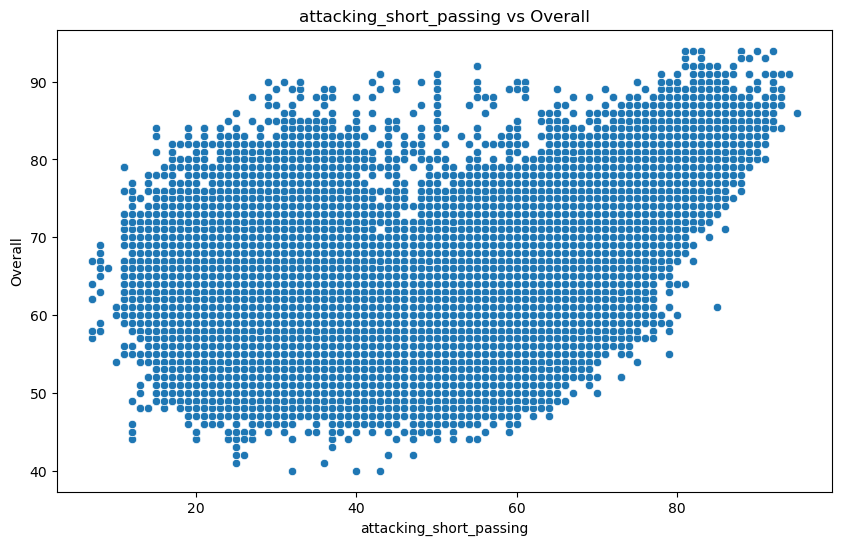

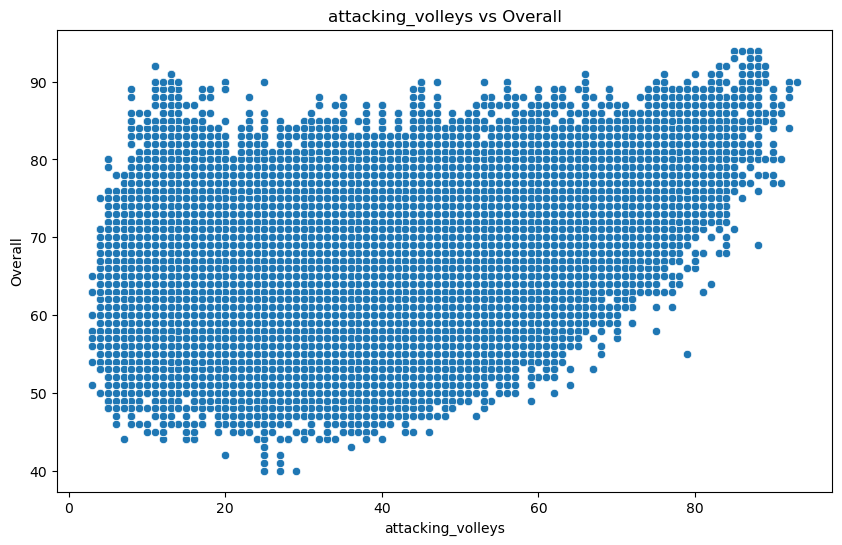

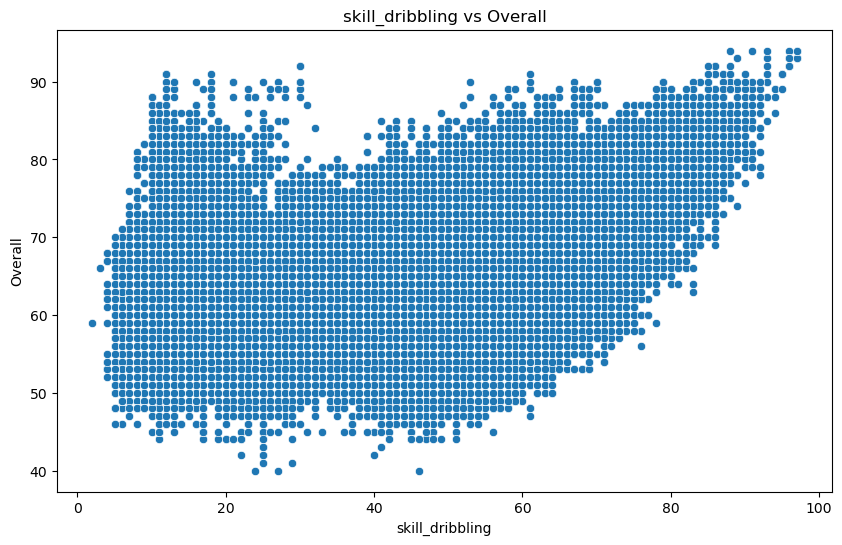

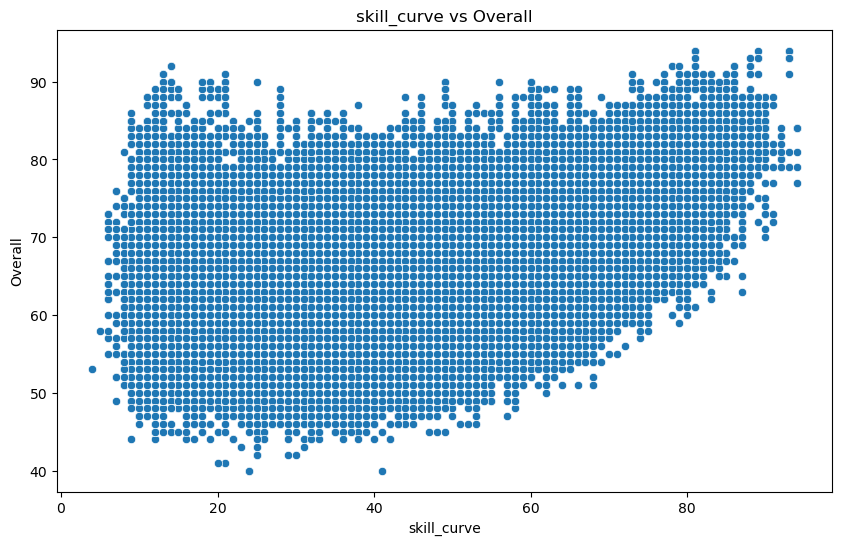

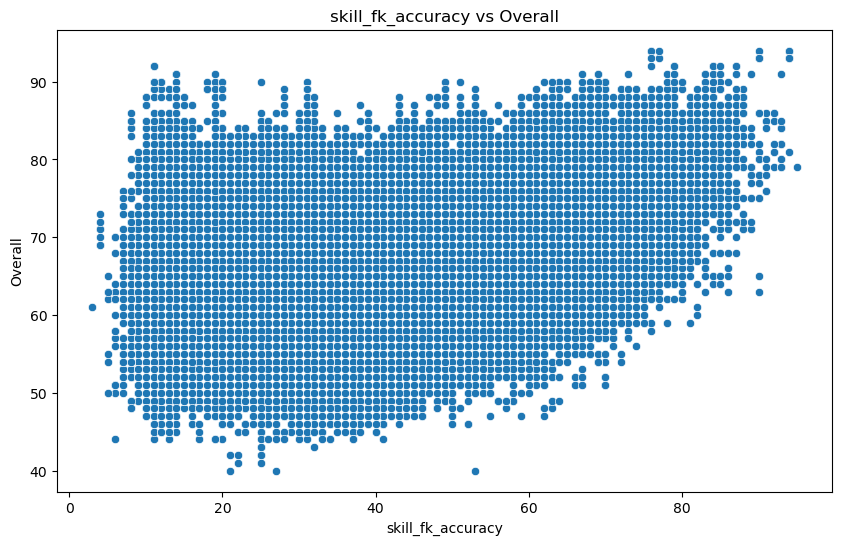

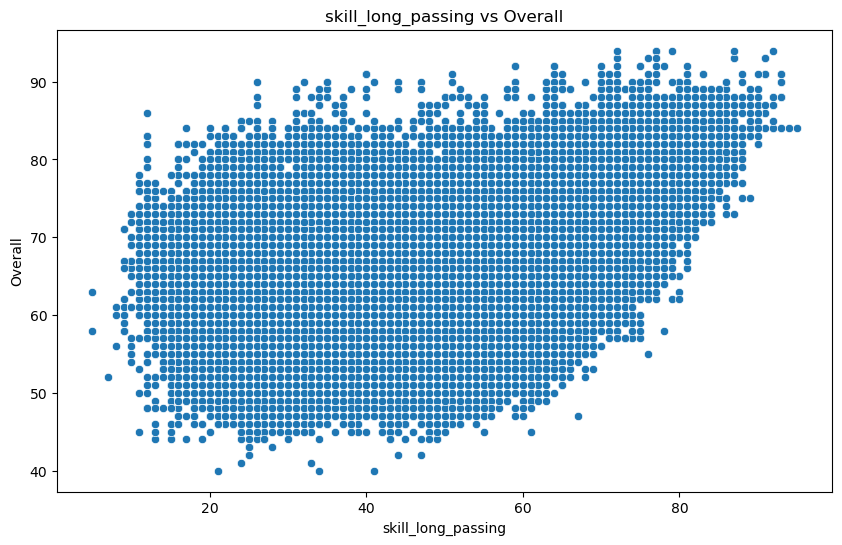

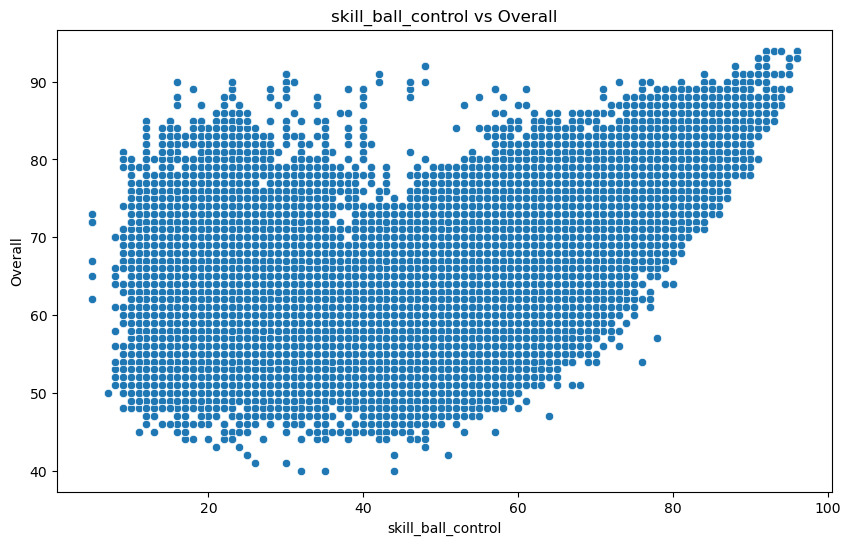

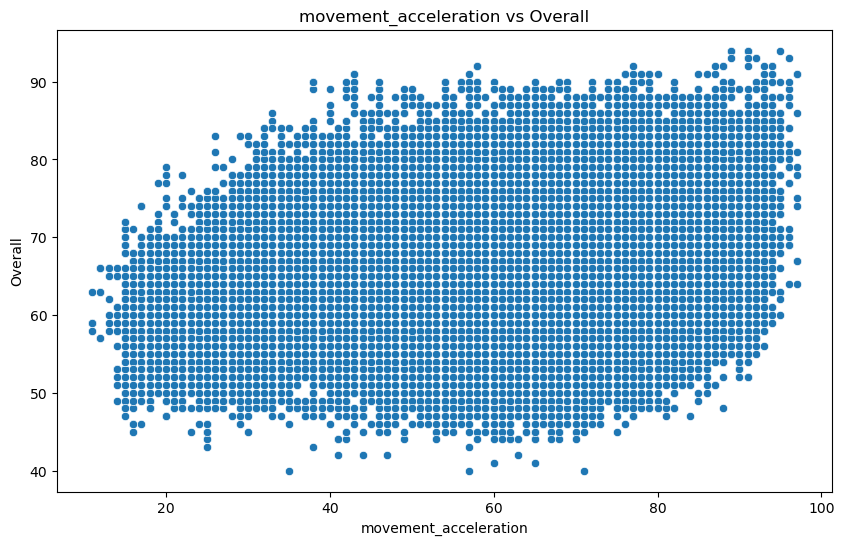

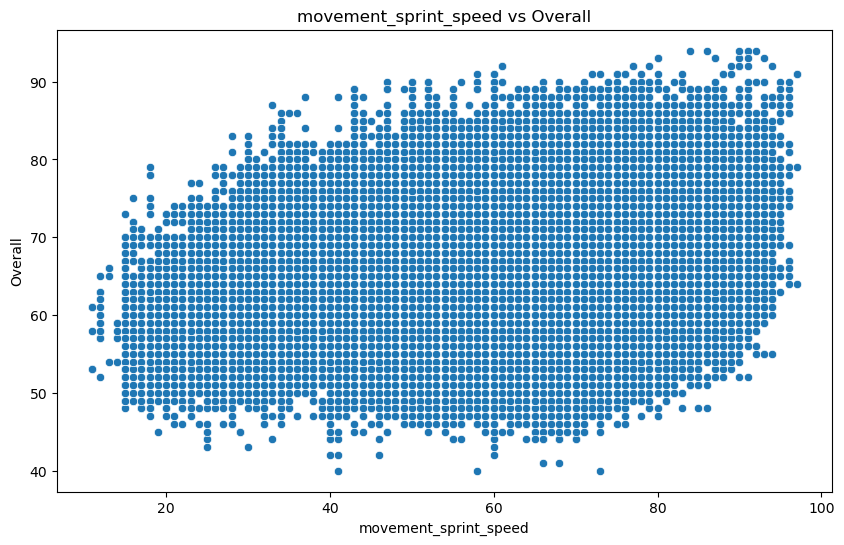

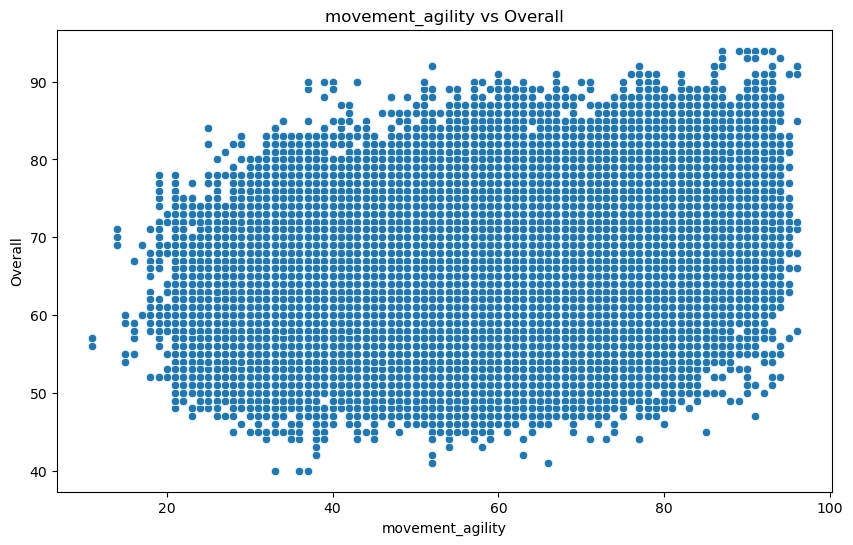

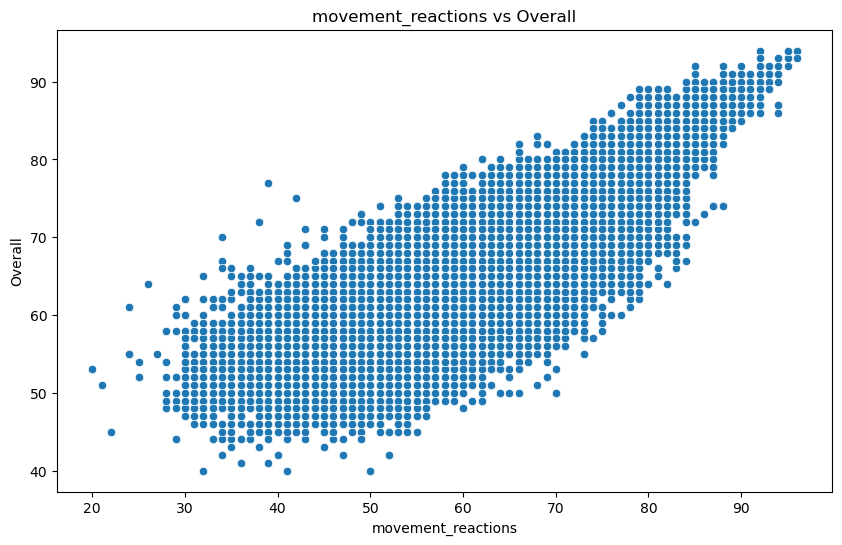

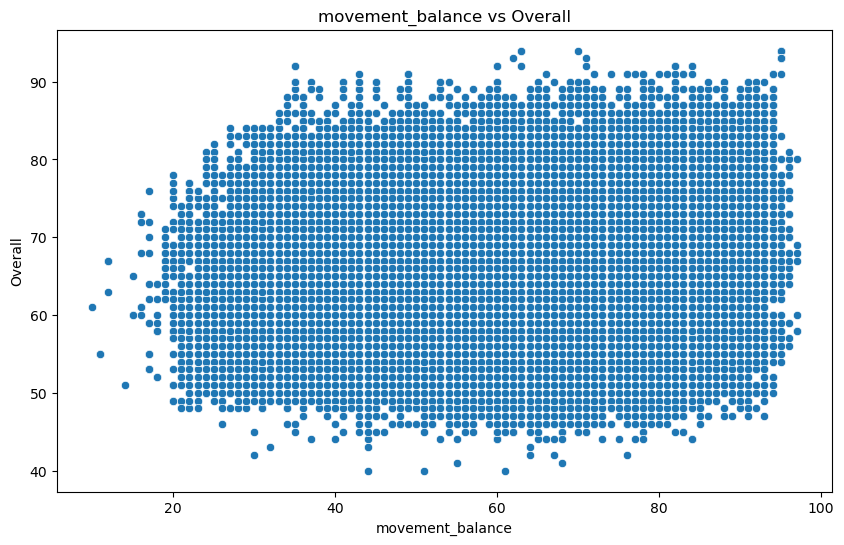

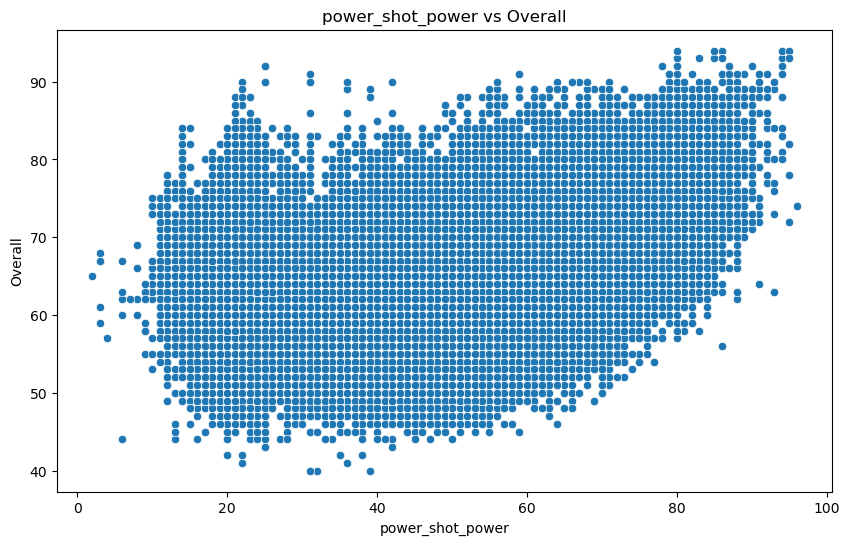

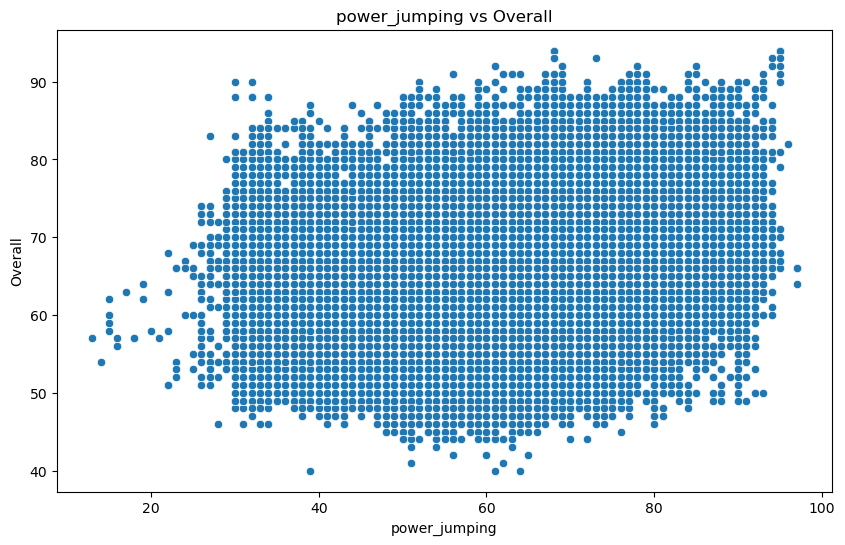

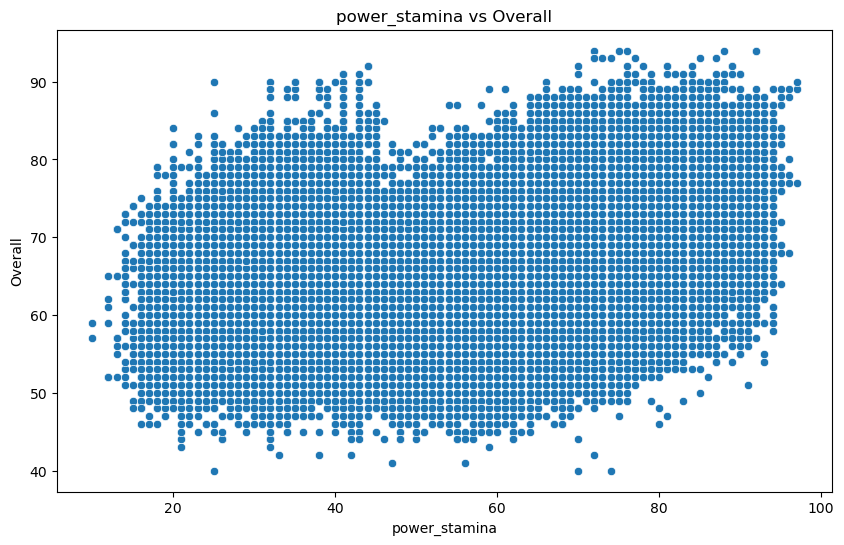

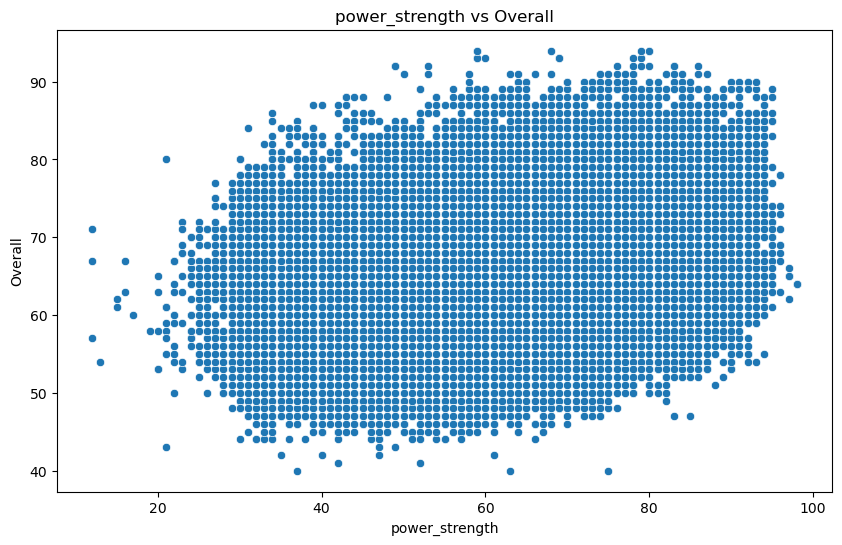

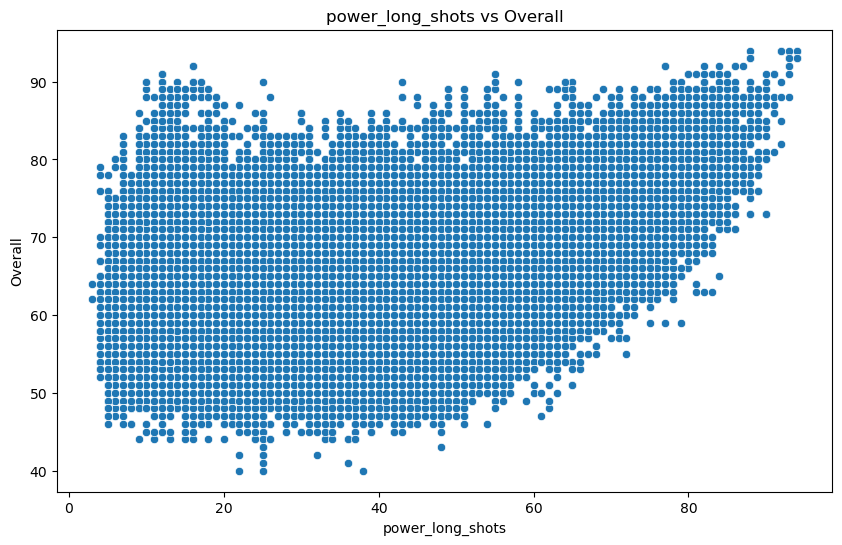

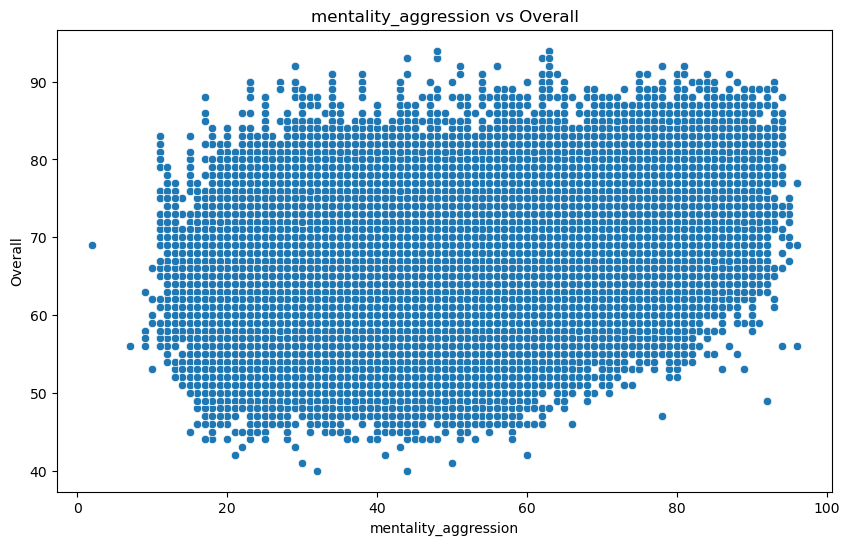

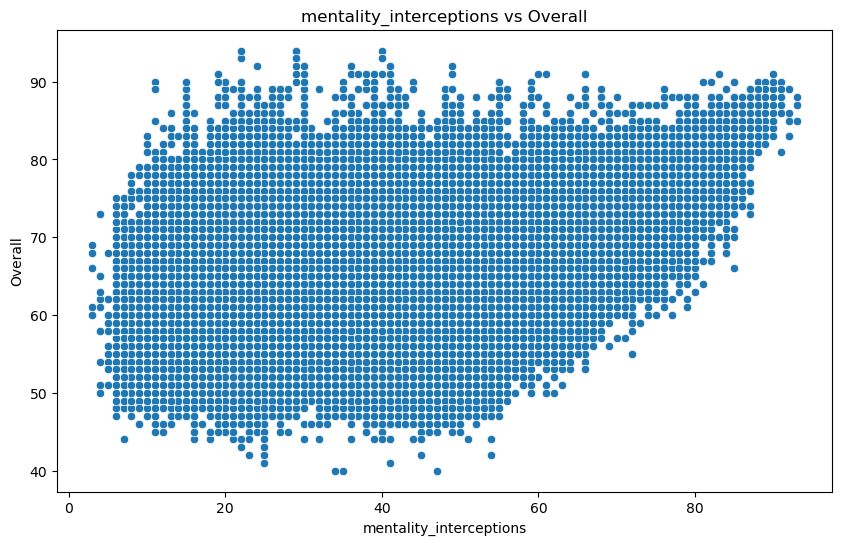

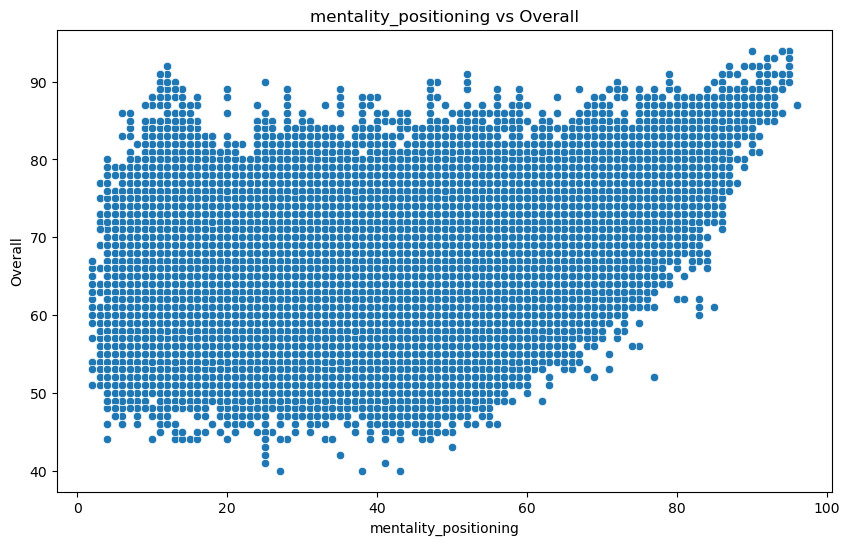

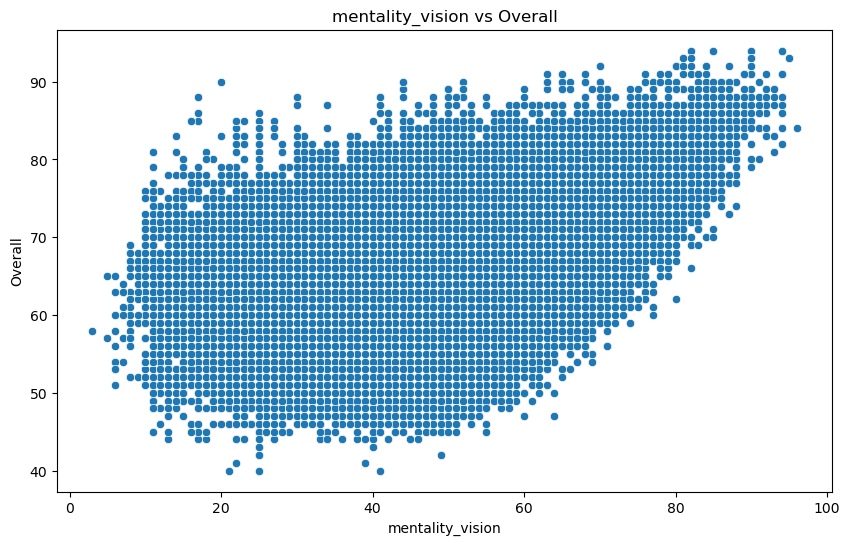

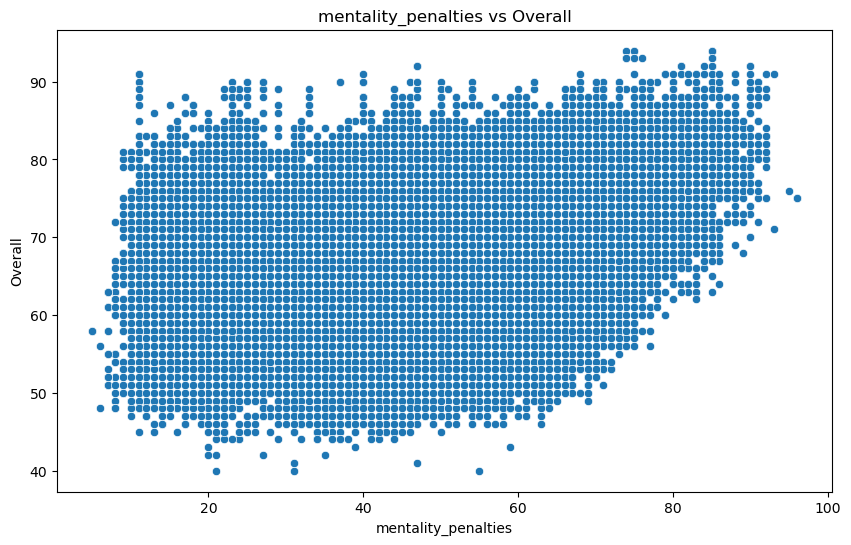

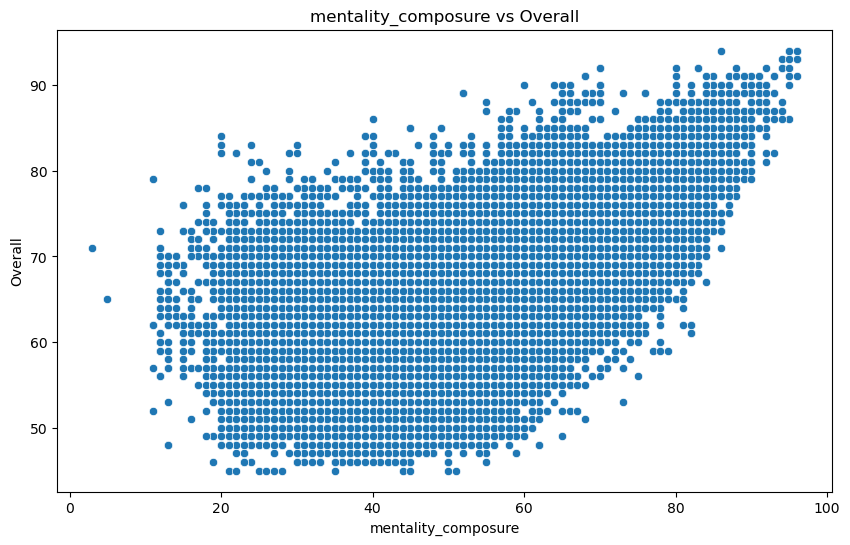

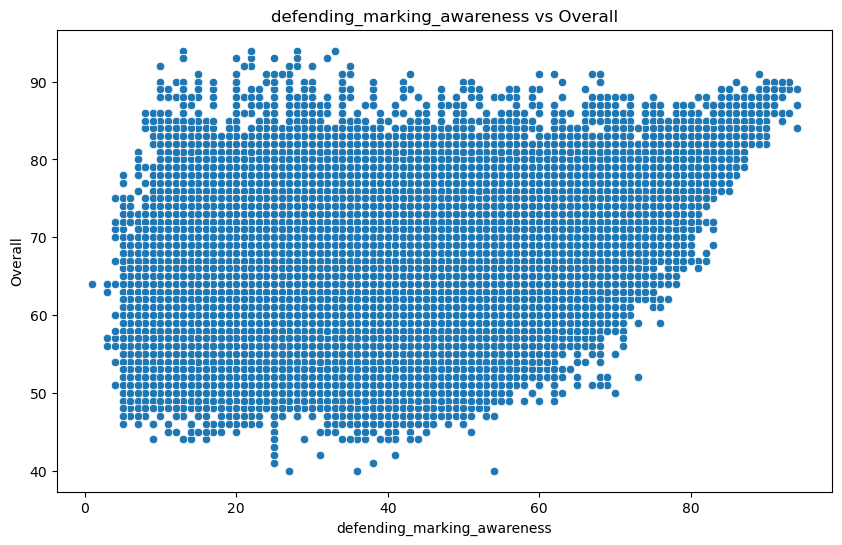

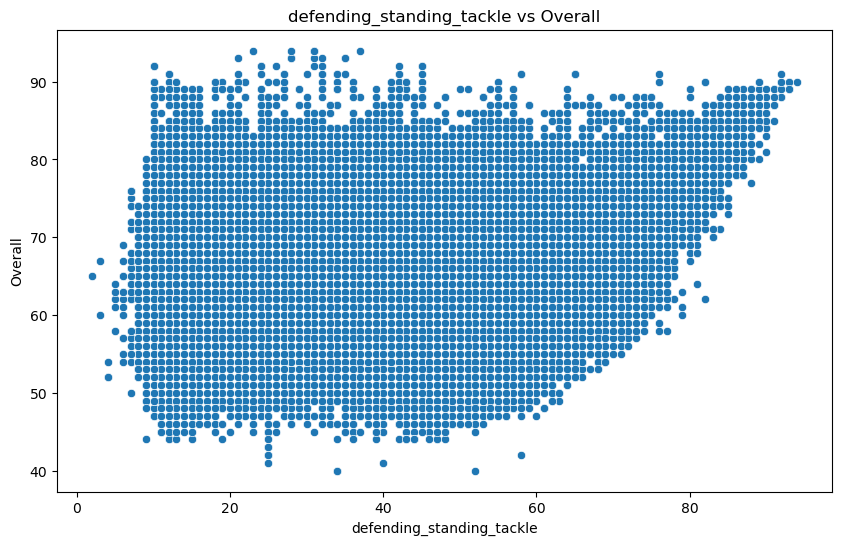

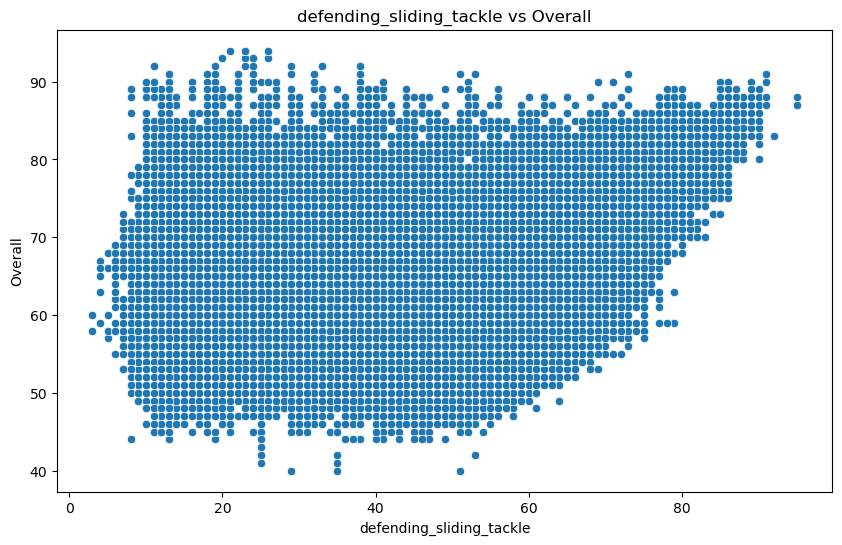

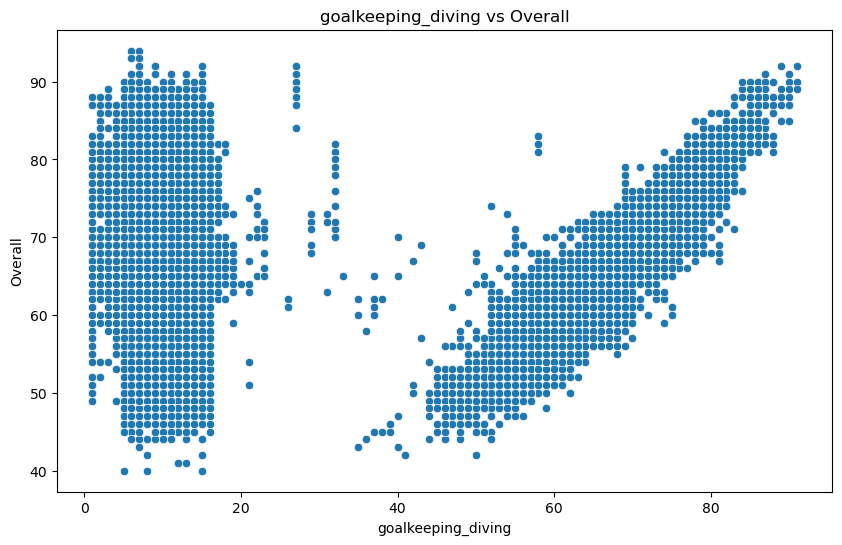

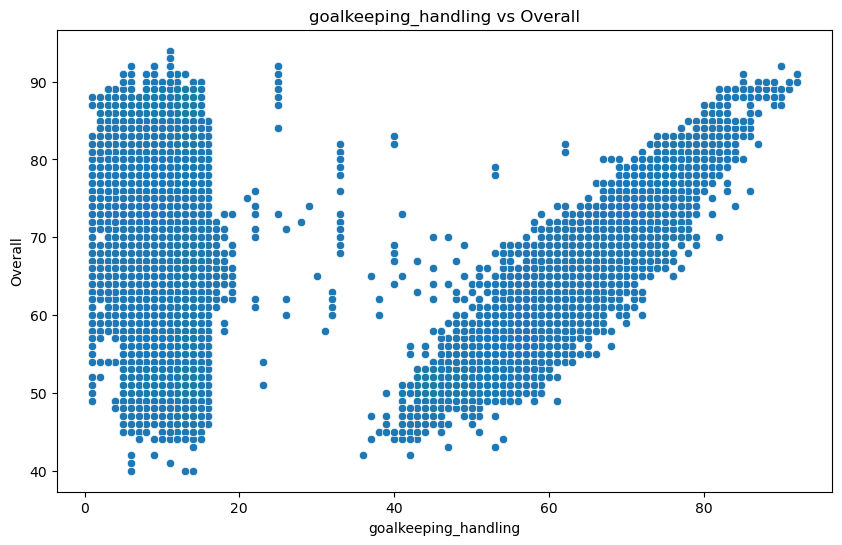

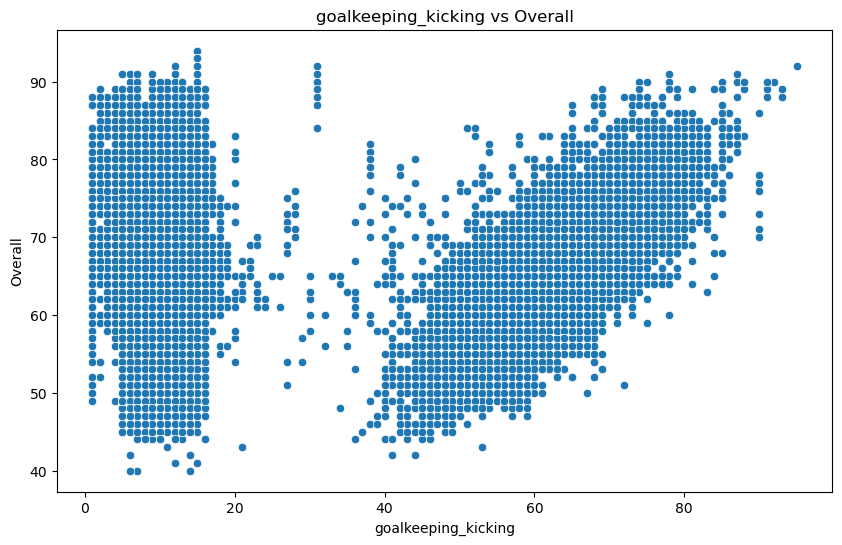

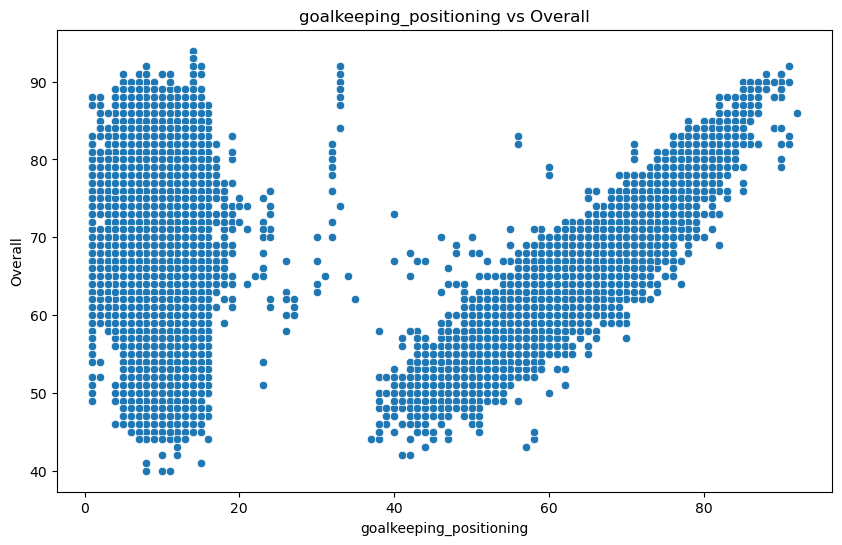

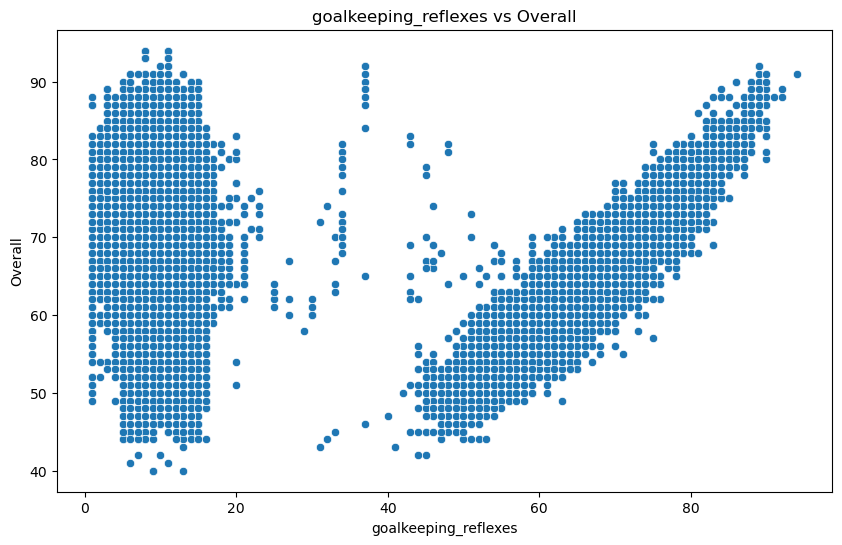

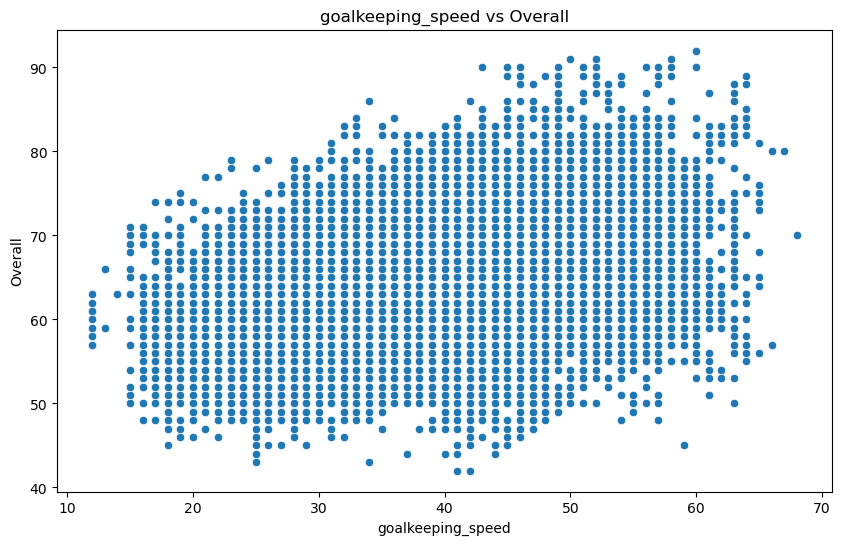

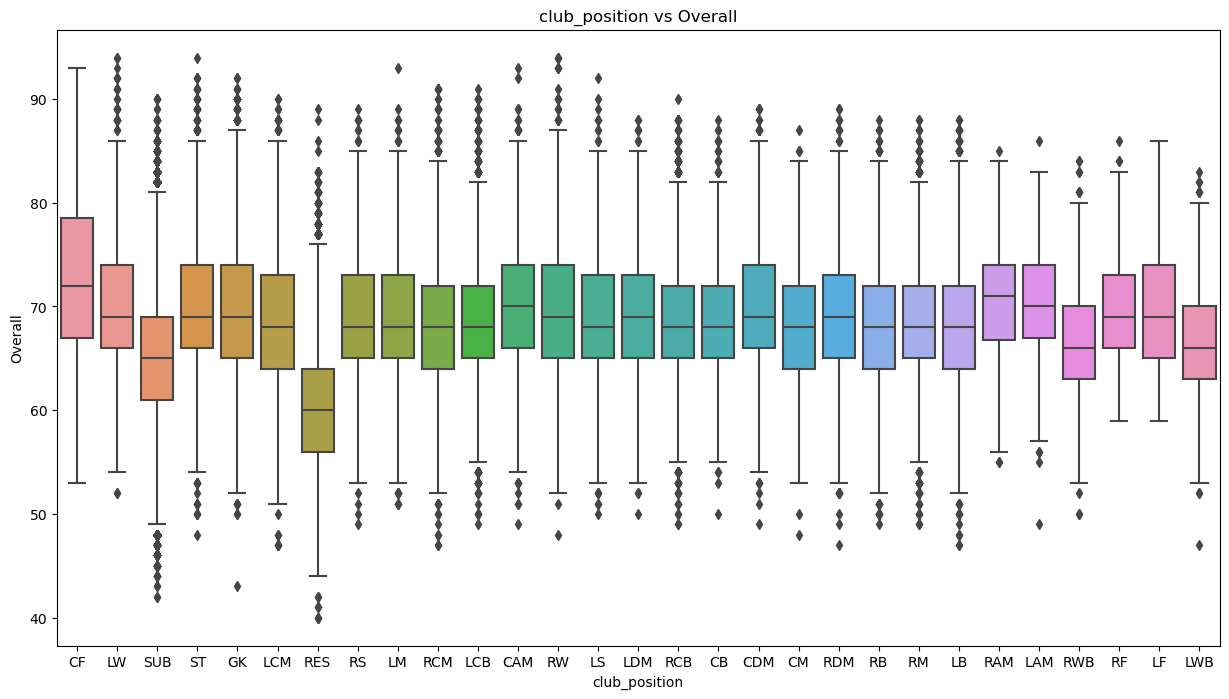

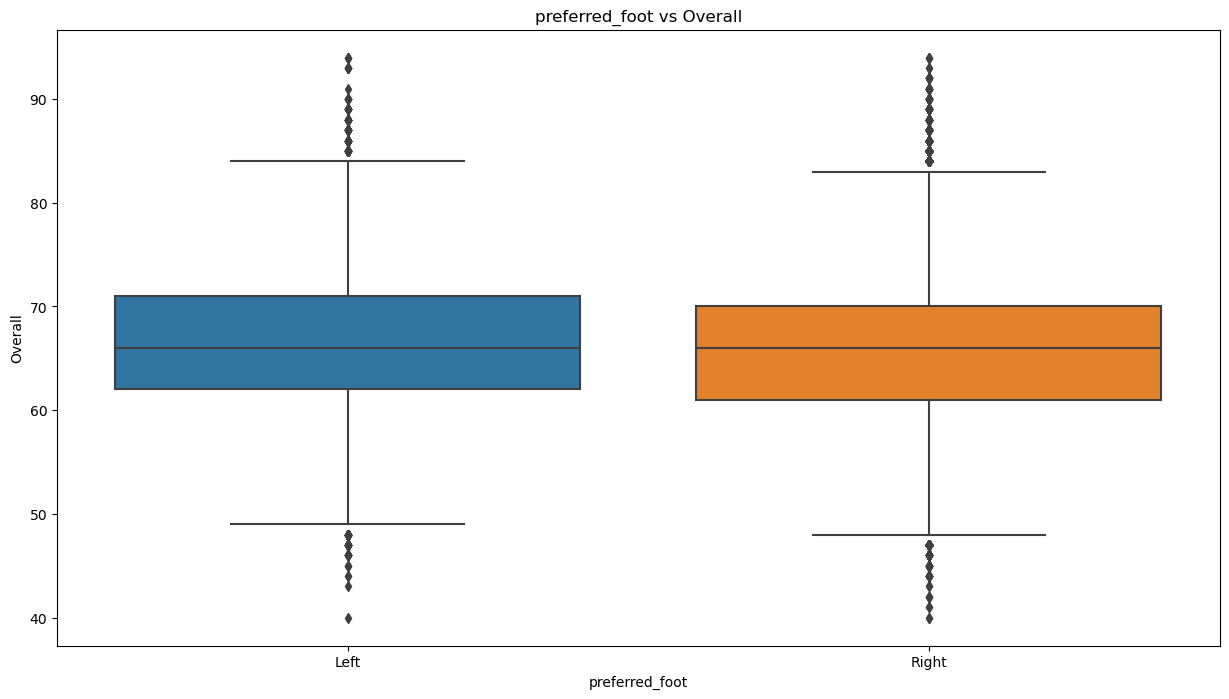

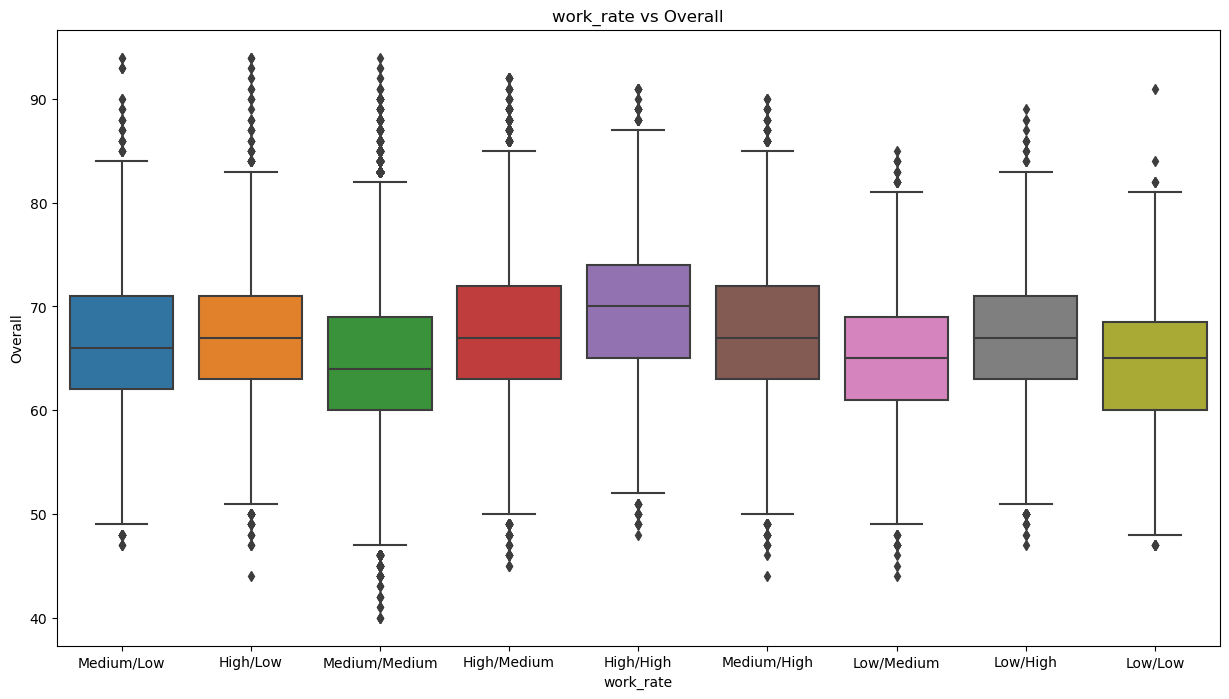

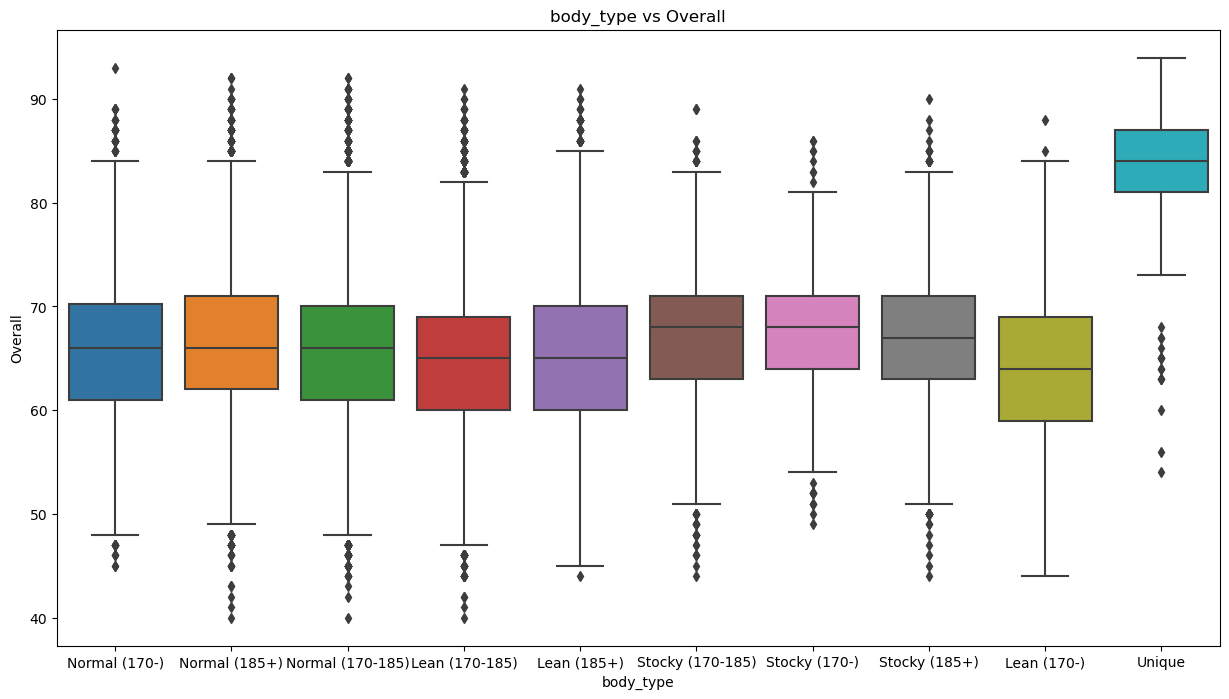

In [6]:
# Scatter plots for numeric features vs 'overall'
for feature in numeric_features:
    if feature != 'overall':
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_train, x=feature, y='overall')
        plt.title(f'{feature} vs Overall')
        plt.xlabel(feature)
        plt.ylabel('Overall')
        plt.show()

# Box plots for categorical features vs 'overall'
for feature in categorical_features:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df_train, x=feature, y='overall')
    plt.title(f'{feature} vs Overall')
    plt.xlabel(feature)
    plt.ylabel('Overall')
    plt.show()


In [7]:
# One-hot encoding for categorical features
df_train_encoded = df_train.copy()
df_train_encoded = pd.get_dummies(df_train_encoded, columns=categorical_features.columns, drop_first=True)

In [8]:
# Compute the correlation matrix
corr_matrix = df_train_encoded.corr()

In [9]:
# Filter features with a high correlation to 'overall'
correlation_threshold = 0.5
high_corr_features = corr_matrix.index[abs(corr_matrix["overall"]) > correlation_threshold].tolist()

# Create a dataset with selected features and some categorical features
selected_features_train = df_train[high_corr_features + ['work_rate', 'body_type']]
selected_features_test = df_test[high_corr_features + ['work_rate', 'body_type']]


In [10]:
# Filter columns with 30% or more missing values
L =[]
L_less =[]
for i in selected_features_train.columns:
    if((selected_features_train[i].isnull().sum()) < (0.3*(df_train.shape[0]))):
        L.append(i)
    else:
        L_less.append(i)

selected_features_train = selected_features_train[L]
selected_features_test = selected_features_test[L]

In [11]:
# Separate numeric and non_numeric data
numeric_data_train = selected_features_train.select_dtypes(include=np.number)
numeric_data_test = selected_features_test.select_dtypes(include=np.number)

non_numeric_train = selected_features_train.select_dtypes(include = ['object'])
non_numeric_test = selected_features_test.select_dtypes(include = ['object'])

In [12]:
# Fill missing values in the numeric dataset
imp = IterativeImputer(max_iter=10, random_state=0)
numeric_data_train = pd.DataFrame(np.round(imp.fit_transform(numeric_data_train)), columns=numeric_data_train.columns)
numeric_data_test = pd.DataFrame(np.round(imp.fit_transform(numeric_data_test)), columns=numeric_data_test.columns)

In [13]:
# Fill missing values in the non_numeric dataset
cat_imputer = SimpleImputer(strategy='most_frequent')
non_numeric_train = pd.DataFrame(cat_imputer.fit_transform(non_numeric_train), columns=non_numeric_train.columns)
non_numeric_test = pd.DataFrame(cat_imputer.fit_transform(non_numeric_test), columns=non_numeric_test.columns)

In [14]:
# One Hot Encode non-numeric features
non_numeric_train = pd.get_dummies(non_numeric_train).astype(int)
non_numeric_test = pd.get_dummies(non_numeric_test).astype(int)

In [15]:
# Prepare final datasets
YTrain = numeric_data_train['overall']
YTest = numeric_data_test['overall']
XTrain = pd.concat([numeric_data_train.drop('overall', axis=1), non_numeric_train],axis=1)
XTest = pd.concat([numeric_data_test.drop('overall', axis=1), non_numeric_test],axis=1)

In [16]:
# Scale features
scaler = StandardScaler()
XTrain = scaler.fit_transform(XTrain)
XTest = scaler.fit_transform(XTest)

In [17]:
# Function to train and evaluate models
def evaluate_models(models, XTrain, YTrain, XTest, YTest):
    results = {}
    predictions = {}
    
    for name, model in models.items():
        model.fit(XTrain, YTrain)
        y_pred = model.predict(XTest)
        mse = mean_squared_error(YTest, y_pred)
        results[name] = mse
        predictions[name] = pd.DataFrame({'Actual': YTest, 'Predicted': y_pred})
        print(f"{name}: Mean Squared Error = {mse}")
    
    return results, predictions

In [18]:
# Train and evaluate models
models = {
    'Gradient Boosting': GradientBoostingRegressor(),
    'Bagging': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGB': XGBRegressor()
}
# Evaluate models
results, predictions = evaluate_models(models, XTrain, YTrain, XTest, YTest)

print(results)
print(predictions)

Gradient Boosting: Mean Squared Error = 3.92366000430319
Bagging: Mean Squared Error = 2.763629317763108
Random Forest: Mean Squared Error = 2.481851812741568
XGB: Mean Squared Error = 2.517785741501802
{'Gradient Boosting': 3.92366000430319, 'Bagging': 2.763629317763108, 'Random Forest': 2.481851812741568, 'XGB': 2.517785741501802}
{'Gradient Boosting':        Actual  Predicted
0        93.0  89.075354
1        92.0  89.398018
2        91.0  88.557266
3        91.0  89.363722
4        91.0  90.089675
...       ...        ...
19234    47.0  52.341610
19235    47.0  53.467446
19236    47.0  52.868683
19237    47.0  52.774569
19238    47.0  53.620007

[19239 rows x 2 columns], 'Bagging':        Actual  Predicted
0        93.0       92.3
1        92.0       91.7
2        91.0       91.4
3        91.0       90.7
4        91.0       90.9
...       ...        ...
19234    47.0       54.5
19235    47.0       51.2
19236    47.0       51.9
19237    47.0       52.4
19238    47.0       52.9

[192

In [19]:
# Prepare another dataset for train and test with just the earlier selected numeric features
YTrain = numeric_data_train['overall']
YTest = numeric_data_test['overall']
XTrain = numeric_data_train.drop('overall', axis=1)
XTest = numeric_data_test.drop('overall', axis=1)

In [20]:
# Scale features
scaler = StandardScaler()
XTrain = scaler.fit_transform(XTrain)
XTest = scaler.fit_transform(XTest)

In [21]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [22]:
# Train and evaluate earlier define models
results, predictions = evaluate_models(models, XTrain, YTrain, XTest, YTest)

print(results)
print(predictions)

Gradient Boosting: Mean Squared Error = 3.9134506953672052
Bagging: Mean Squared Error = 2.7442557110556685
Random Forest: Mean Squared Error = 2.57768368662468
XGB: Mean Squared Error = 2.477406922559468
{'Gradient Boosting': 3.9134506953672052, 'Bagging': 2.7442557110556685, 'Random Forest': 2.57768368662468, 'XGB': 2.477406922559468}
{'Gradient Boosting':        Actual  Predicted
0        93.0  89.495966
1        92.0  89.651896
2        91.0  88.712407
3        91.0  89.425937
4        91.0  90.399770
...       ...        ...
19234    47.0  52.302801
19235    47.0  53.479113
19236    47.0  52.755028
19237    47.0  52.749500
19238    47.0  53.427449

[19239 rows x 2 columns], 'Bagging':        Actual  Predicted
0        93.0       92.1
1        92.0       91.7
2        91.0       90.9
3        91.0       91.1
4        91.0       91.0
...       ...        ...
19234    47.0       54.6
19235    47.0       52.1
19236    47.0       52.0
19237    47.0       52.1
19238    47.0       53.8



In [23]:
# Function to evaluate voting ensemble model
def evaluate_voting_ensemble(voting_ensemble, XTrain, YTrain, XTest, YTest):
    # Make predictions
    train_predictions = voting_ensemble.predict(XTrain)
    test_predictions = voting_ensemble.predict(XTest)

    predictions= pd.DataFrame({'Actual': YTest, 'Predicted': test_predictions})

    # Evaluate predictions
    mse_train = mean_squared_error(YTrain, train_predictions)
    mse_test = mean_squared_error(YTest, test_predictions)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    return rmse_train, rmse_test, mse_train, mse_test, predictions

In [24]:
# Initialize the models
rf = RandomForestRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse')

In [27]:
# Define the parameter grids for different models
rf_param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6]
}

bagging_param_grid = {
    'n_estimators': [10, 20, 40],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [29]:
# Apply GridSearchCV for RandomForestRegressor
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(XTrain, YTrain)
best_rf_model = rf_grid_search.best_estimator_

# Apply GridSearchCV for BaggingRegressor
bagging_grid_search = GridSearchCV(estimator=bagging, param_grid=bagging_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
bagging_grid_search.fit(XTrain, YTrain)
best_bagging_model = bagging_grid_search.best_estimator_

# Apply GridSearchCV for XGBRegressor
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid_search.fit(XTrain, YTrain)
best_xgb_model = xgb_grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


In [31]:
# Print best parameters
print(f'Best parameters for Random Forest: {rf_grid_search.best_params_}')
print(f'Best parameters for Bagging Regressor: {bagging_grid_search.best_params_}')
print(f'Best parameters for XGB Regressor: {xgb_grid_search.best_params_}')

Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 400}
Best parameters for Bagging Regressor: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 40}
Best parameters for XGB Regressor: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.9}


In [45]:
# Create a Voting Regressor with the best models
voting_ensemble = VotingRegressor(estimators=[
    ('rf', best_rf_model),
    ('bagging', best_bagging_model),
    ('xgb', best_xgb_model)
])

# Train the voting ensemble
voting_ensemble.fit(XTrain, YTrain)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=30,
                                                   min_samples_leaf=4,
                                                   min_samples_split=5,
                                                   n_estimators=400,
                                                   random_state=42)),
                            ('bagging',
                             BaggingRegressor(max_features=0.5, n_estimators=40,
                                              random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0....
                                          feature_types=None, gamma=0.2,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=400,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))])

In [47]:
# Evaluate the ensemble model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(voting_ensemble, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 0.9933641957274023
Voting Ensemble Test RMSE: 1.6474616863401494
Voting Ensemble Train MSE: 0.9867724253531488
Voting Ensemble Test MSE: 2.714130007958729
       Actual  Predicted
0        93.0  92.101522
1        92.0  90.612636
2        91.0  90.171712
3        91.0  90.786751
4        91.0  90.833314
...       ...        ...
19234    47.0  52.670318
19235    47.0  53.489329
19236    47.0  52.858854
19237    47.0  52.699374
19238    47.0  53.876955

[19239 rows x 2 columns]


In [51]:
# Create a Voting Regressor with the best models
voting_ensemble1 = VotingRegressor(estimators=[
    ('rf', best_rf_model),
    ('xgb', best_xgb_model)
])

# Train the voting ensemble
voting_ensemble1.fit(XTrain, YTrain)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=30,
                                                   min_samples_leaf=4,
                                                   min_samples_split=5,
                                                   n_estimators=400,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='...
                                          feature_types=None, gamma=0.2,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=400,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))])

In [53]:
# Evaluate the ensemble model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(voting_ensemble1, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 1.1628344129027892
Voting Ensemble Test RMSE: 1.6424872097359131
Voting Ensemble Train MSE: 1.3521838718309744
Voting Ensemble Test MSE: 2.6977642341460655
       Actual  Predicted
0        93.0  92.102282
1        92.0  90.506454
2        91.0  90.245068
3        91.0  90.630126
4        91.0  90.837470
...       ...        ...
19234    47.0  52.646101
19235    47.0  53.218994
19236    47.0  52.507032
19237    47.0  52.324061
19238    47.0  53.477933

[19239 rows x 2 columns]


In [41]:
# Evaluate the  model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(best_rf_model, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 0.8440863826394895
Voting Ensemble Test RMSE: 1.6433489426785706
Voting Ensemble Train MSE: 0.7124818213574188
Voting Ensemble Test MSE: 2.700595747402776
       Actual  Predicted
0        93.0  92.299070
1        92.0  90.949379
2        91.0  90.779396
3        91.0  90.791655
4        91.0  91.158446
...       ...        ...
19234    47.0  53.730126
19235    47.0  52.791839
19236    47.0  52.189303
19237    47.0  52.476620
19238    47.0  53.463766

[19239 rows x 2 columns]


In [43]:
# Evaluate the ensemble model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(best_xgb_model, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 1.5863917921915125
Voting Ensemble Test RMSE: 1.7857354736287396
Voting Ensemble Train MSE: 2.5166389183325992
Voting Ensemble Test MSE: 3.188851181776059
       Actual  Predicted
0        93.0  91.905495
1        92.0  90.063530
2        91.0  89.710739
3        91.0  90.468597
4        91.0  90.516495
...       ...        ...
19234    47.0  51.562077
19235    47.0  53.646149
19236    47.0  52.824760
19237    47.0  52.171501
19238    47.0  53.492100

[19239 rows x 2 columns]


In [55]:
# Evaluate the ensemble model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(best_bagging_model, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 0.7704643863136684
Voting Ensemble Test RMSE: 1.7479603974849292
Voting Ensemble Train MSE: 0.5936153705776978
Voting Ensemble Test MSE: 3.0553655511756714
       Actual  Predicted
0        93.0   92.10000
1        92.0   90.82500
2        91.0   90.02500
3        91.0   91.10000
4        91.0   90.82500
...       ...        ...
19234    47.0   52.71875
19235    47.0   54.03000
19236    47.0   53.56250
19237    47.0   53.45000
19238    47.0   54.67500

[19239 rows x 2 columns]


In [57]:
voting_ensemble2 = VotingRegressor(estimators=[
    ('rf', best_rf_model),
    ('bagging', best_bagging_model)
])

# Train the voting ensemble
voting_ensemble2.fit(XTrain, YTrain)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=30,
                                                   min_samples_leaf=4,
                                                   min_samples_split=5,
                                                   n_estimators=400,
                                                   random_state=42)),
                            ('bagging',
                             BaggingRegressor(max_features=0.5, n_estimators=40,
                                              random_state=42))])

In [59]:
# Evaluate the ensemble model
rmse_train, rmse_test, mse_train, mse_test, predictions = evaluate_voting_ensemble(voting_ensemble2, XTrain, YTrain, XTest, YTest)

# Print the results
print(f'Voting Ensemble Train RMSE: {rmse_train}')
print(f'Voting Ensemble Test RMSE: {rmse_test}')
print(f'Voting Ensemble Train MSE: {mse_train}')
print(f'Voting Ensemble Test MSE: {mse_test}')

print(predictions)

Voting Ensemble Train RMSE: 0.7465566393814025
Voting Ensemble Test RMSE: 1.6300287242481921
Voting Ensemble Train MSE: 0.5573468158044534
Voting Ensemble Test MSE: 2.656993641874189
       Actual  Predicted
0        93.0  92.199535
1        92.0  90.887189
2        91.0  90.402198
3        91.0  90.945827
4        91.0  90.991723
...       ...        ...
19234    47.0  53.224438
19235    47.0  53.410920
19236    47.0  52.875902
19237    47.0  52.963310
19238    47.0  54.069383

[19239 rows x 2 columns]


In [63]:
# Save the model
joblib.dump(voting_ensemble2, 'model.pkl')

['model.pkl']